# Convolutional Neural Networks and Computer Vision Using TensorFlow


We're going to get specific and see how a special kind of neural network, [convolutional neural networks (CNNs)](https://en.wikipedia.org/wiki/Convolutional_neural_network) can be used for computer vision (detecting patterns in visual data).

In deep learning, many different kinds of model architectures can be used for different problems. For example, you could use a convolutional neural network for making predictions on image data and/or text data. However, in practice some architectures typically work better than others.

For example, you might want to:
* Classify whether a picture of food contains pizza 🍕 or steak 🥩 (we're going to do this)
* Detect whether or not an object appears in an image (e.g. did a specific car pass through a security camera?)


## What we're going to cover

Specifically, we're going to go through the follow with TensorFlow:

- Getting a dataset to work with
- Architecture of a convolutional neural network
- A quick end-to-end example (what we're working towards)
- Steps in modelling for binary image classification with CNNs
  - Becoming one with the data
  - Preparing data for modelling
  - Creating a CNN model (starting with a baseline)
  - Fitting a model (getting it to find patterns in our data)
  - Evaluating a model
  - Improving a model
  - Making a prediction with a trained model
- Steps in modelling for multi-class image classification with CNNs
 - Same as above (but this time with a different dataset).

## Get the data

The images we're going to work with are from the [Food-101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/), a collection of 101 different categories of 101,000 (1000 images per category) real-world images of food dishes. 

To begin, we're only going to use two of the categories, pizza 🍕 and steak 🥩 and build a binary classifier.

We'll download the `pizza_steak` subset .zip file and unzip it.

## Inspect the data

A very crucial step at the beginning of any machine learning project is becoming one with the data. This usually means plenty of visualizing and folder scanning to understand the data you're working with.

The file structure has been formatted to be in a typical format we might use for working with images.

More specifically:
* A `train` directory which contains all of the images in the training dataset with subdirectories each named after a certain class containing images of that class.
* A `test` directory with the same structure as the `train` directory.

```
Example of file structure

pizza_steak <- top level folder
└───train <- training images
│   └───pizza
│   │   │   1008104.jpg
│   │   │   1638227.jpg
│   │   │   ...      
│   └───steak
│       │   1000205.jpg
│       │   1647351.jpg
│       │   ...
│   
└───test <- testing images
│   └───pizza
│   │   │   1001116.jpg
│   │   │   1507019.jpg
│   │   │   ...      
│   └───steak
│       │   100274.jpg
│       │   1653815.jpg
│       │   ...    
 ```

In [1]:
import os

In [2]:
os.listdir("pizza_steak")

['test', 'train']

In [3]:
# walk Through pizza_steak Directory and list Number of Files:

for dirpath, dirnames, filenames in os.walk("pizza_steak"):
    print(f"There are {len(dirnames)} Directories and {len(filenames)} Images in {dirpath}")

There are 2 Directories and 0 Images in pizza_steak
There are 2 Directories and 0 Images in pizza_steak\test
There are 0 Directories and 250 Images in pizza_steak\test\pizza
There are 0 Directories and 250 Images in pizza_steak\test\steak
There are 2 Directories and 0 Images in pizza_steak\train
There are 0 Directories and 750 Images in pizza_steak\train\pizza
There are 0 Directories and 750 Images in pizza_steak\train\steak


In [4]:
# Getting Names of Classes Programmatically:

import pathlib
import numpy as np

datadir = pathlib.Path("pizza_steak\\train\\")
class_names = np.array(sorted(item.name for item in datadir.glob("*")))

In [5]:
class_names

array(['pizza', 'steak'], dtype='<U5')

In [6]:
list(datadir.glob("*"))

[WindowsPath('pizza_steak/train/pizza'),
 WindowsPath('pizza_steak/train/steak')]

In [7]:
# Viewing an Image:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
    
    # Setup Target Directory to View Image:
    target_folder = target_dir+target_class
    
    # Get a Random Image Path:
    random_image = random.sample(os.listdir(target_folder), 1)
    
    # Read in The Selected Image and Plot it:
    img = plt.imread(target_folder+"\\"+random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    
    return img

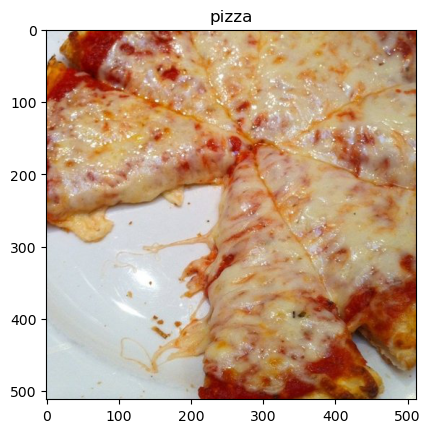

In [8]:
image = view_random_image(target_dir= "pizza_steak\\train\\",
                         target_class= "pizza")

In [9]:
image

array([[[212, 219, 227],
        [211, 218, 226],
        [211, 218, 226],
        ...,
        [139,  45,  20],
        [137,  45,  20],
        [136,  44,  19]],

       [[215, 222, 230],
        [213, 220, 228],
        [212, 219, 227],
        ...,
        [135,  40,  18],
        [135,  43,  18],
        [137,  45,  20]],

       [[217, 224, 232],
        [216, 223, 231],
        [214, 221, 229],
        ...,
        [131,  36,  14],
        [135,  40,  18],
        [138,  43,  21]],

       ...,

       [[206, 218, 216],
        [204, 216, 214],
        [203, 215, 215],
        ...,
        [221, 225, 211],
        [221, 225, 211],
        [235, 238, 227]],

       [[206, 218, 216],
        [204, 216, 214],
        [203, 215, 215],
        ...,
        [216, 220, 206],
        [225, 229, 215],
        [236, 240, 226]],

       [[208, 220, 218],
        [205, 217, 215],
        [204, 216, 216],
        ...,
        [231, 235, 220],
        [253, 255, 243],
        [246, 250, 236]]

In [10]:
image.shape

(512, 512, 3)

Looking at the image shape more closely, you'll see it's in the form `(Width, Height, Colour Channels)`.

In our case, the width and height vary but because we're dealing with colour images, the colour channels value is always 3. This is for different values of [red, green and blue (RGB) pixels](https://en.wikipedia.org/wiki/RGB_color_model).

You'll notice all of the values in the `img` array are between 0 and 255. This is because that's the possible range for red, green and blue values.

For example, a pixel with a value `red=0, green=0, blue=255` will look very blue.

So when we build a model to differentiate between our images of `pizza` and `steak`, it will be finding patterns in these different pixel values which determine what each class looks like.

Many machine learning models, including neural networks prefer the values they work with to be between 0 and 1. Knowing this, one of the most common preprocessing steps for working with images is to **scale** (also referred to as **normalize**) their pixel values by dividing the image arrays by 255.

In [11]:
image.max(), image.min()

(255, 0)

In [12]:
# Getting all Pixel values Between 0 and 1:
image/255

array([[[0.83137255, 0.85882353, 0.89019608],
        [0.82745098, 0.85490196, 0.88627451],
        [0.82745098, 0.85490196, 0.88627451],
        ...,
        [0.54509804, 0.17647059, 0.07843137],
        [0.5372549 , 0.17647059, 0.07843137],
        [0.53333333, 0.17254902, 0.0745098 ]],

       [[0.84313725, 0.87058824, 0.90196078],
        [0.83529412, 0.8627451 , 0.89411765],
        [0.83137255, 0.85882353, 0.89019608],
        ...,
        [0.52941176, 0.15686275, 0.07058824],
        [0.52941176, 0.16862745, 0.07058824],
        [0.5372549 , 0.17647059, 0.07843137]],

       [[0.85098039, 0.87843137, 0.90980392],
        [0.84705882, 0.8745098 , 0.90588235],
        [0.83921569, 0.86666667, 0.89803922],
        ...,
        [0.51372549, 0.14117647, 0.05490196],
        [0.52941176, 0.15686275, 0.07058824],
        [0.54117647, 0.16862745, 0.08235294]],

       ...,

       [[0.80784314, 0.85490196, 0.84705882],
        [0.8       , 0.84705882, 0.83921569],
        [0.79607843, 0

## A (typical) architecture of a convolutional neural network

Components of a convolutional neural network:

| **Hyperparameter/Layer type** | **What does it do?** | **Typical values** |
| ----- | ----- | ----- |
| Input image(s) | Target images you'd like to discover patterns in| Whatever you can take a photo (or video) of |
| Input layer | Takes in target images and preprocesses them for further layers | `input_shape = [batch_size, image_height, image_width, color_channels]` |
| Convolution layer | Extracts/learns the most important features from target images | Multiple, can create with [`tf.keras.layers.ConvXD`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) (X can be multiple values) |
| Hidden activation | Adds non-linearity to learned features (non-straight lines) | Usually ReLU ([`tf.keras.activations.relu`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu)) |
| Pooling layer | Reduces the dimensionality of learned image features | Average ([`tf.keras.layers.AvgPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D)) or Max ([`tf.keras.layers.MaxPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)) |
| Fully connected layer | Further refines learned features from convolution layers | [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) |
| Output layer | Takes learned features and outputs them in shape of target labels | `output_shape = [number_of_classes]` (e.g. 3 for pizza, steak or sushi)|
| Output activation | Adds non-linearities to output layer | [`tf.keras.activations.sigmoid`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid) (binary classification) or [`tf.keras.activations.softmax`](https://www.tensorflow.org/api_docs/python/tf/keras/activations/softmax) |

How they stack together:

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-simple-convnet.png)

## An end-to-end example

In [13]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings("ignore")

**Great Resource to Understand CNN**

https://poloclub.github.io/cnn-explainer/

In [14]:
# Building Convolutional Neural Network:

tf.random.set_seed(42)

# Pre-Process Data (Getting all Pixel Values Between 0 and 255)
train_datagen = ImageDataGenerator(rescale= 1/255.0)
valid_datagen = ImageDataGenerator(rescale= 1/255.0)

# Setup Paths to Directories:
train_dir = "pizza_steak\\train\\"
test_dir = "pizza_steak\\test\\"

# import Images from Directories and Turn it Into Batches:
train_data = train_datagen.flow_from_directory(directory= train_dir,
                                              target_size= (224,224),
                                              batch_size= 32,
                                              class_mode= "binary",
                                              seed= 42)

valid_data = valid_datagen.flow_from_directory(directory= test_dir,
                                              target_size= (224,224),
                                              batch_size= 32,
                                              class_mode= "binary",
                                              seed= 42)

# Create a CNN Model:

model_1 = Sequential()

model_1.add(InputLayer(shape=(224,224,3)))

model_1.add(Conv2D(filters= 10,
                  kernel_size= 3,
                  activation= "relu"))

model_1.add(Conv2D(10, 3, activation= "relu"))

model_1.add(MaxPool2D(pool_size=2,
                     padding= "valid"))

model_1.add(Conv2D(10, 3, activation= "relu"))

model_1.add(Conv2D(10, 3, activation= "relu"))

model_1.add(MaxPool2D(pool_size=2))

model_1.add(Flatten())

model_1.add(Dense(1, activation= "sigmoid"))

model_1.compile(optimizer= tf.keras.optimizers.Adam(),
               loss= "binary_crossentropy",
               metrics= ["accuracy"])

history_1 = model_1.fit(train_data,
                       epochs= 5,
                        validation_data= valid_data)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 23s 388ms/step - accuracy: 0.6006 - loss: 0.6498 - val_accuracy: 0.7000 - val_loss: 0.5320
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 297ms/step - accuracy: 0.7667 - loss: 0.4932 - val_accuracy: 0.8400 - val_loss: 0.3906
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 297ms/step - accuracy: 0.8202 - loss: 0.4195 - val_accuracy: 0.8100 - val_loss: 0.3920
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 15s 298ms/step - accuracy: 0.8272 - loss: 0.3919 - val_accuracy: 0.8420 - val_loss: 0.3756
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 14s 277ms/step - accuracy: 0.8677 - loss: 0.3406 - val_accuracy: 0.8640 - val_loss: 0.3116


In [15]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 106, 106, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28090)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        28,091 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,305 (364.48 KB)

 Trainable params: 31,101 (121.49 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,204 (242.99 KB)

## Using the same model as before

To examplify how neural networks can be adapted to many different problems, let's see how a binary classification model we've previously built might work with our data.

We can use all of the same parameters in our previous model except for changing two things:
* **The data** - we're now working with images instead of dots.
* **The input shape** - we have to tell our neural network the shape of the images we're working with.
  * A common practice is to reshape images all to one size. In our case, we'll resize the images to `(224, 224, 3)`, meaning a height and width of 224 pixels and a depth of 3 for the red, green, blue colour channels.

In [16]:
tf.random.set_seed(42)

model_2 = Sequential()

model_2.add(InputLayer(shape= (224,224,3)))
model_2.add(Flatten())

model_2.add(Dense(4, activation= "relu"))
model_2.add(Dense(4, activation= "relu"))
model_2.add(Dense(1, activation= "sigmoid"))

model_2.compile(optimizer= tf.keras.optimizers.Adam(),
               loss= tf.keras.losses.BinaryCrossentropy,
               metrics= ["accuracy"])

history_2= model_2.fit(train_data,
           epochs=5,
           validation_data= valid_data)

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 226ms/step - accuracy: 0.4922 - loss: 2.6285 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 221ms/step - accuracy: 0.4972 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 214ms/step - accuracy: 0.4882 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 213ms/step - accuracy: 0.4860 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 211ms/step - accuracy: 0.5143 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6932


In [17]:
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │       602,116 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,806,425 (6.89 MB)

 Trainable params: 602,141 (2.30 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,204,284 (4.59 MB)

One of the most noticeable things here is the much larger number of parameters in `model_2` versus `model_1`.

`model_2` has 602,141 trainable parameters where as `model_1` has only 31,101. And despite this difference, `model_1` still far and large out performs `model_2`.

You can think of trainable parameters as *patterns a model can learn from data*. Intuitiely, you might think more is better. And in some cases it is. But in this case, the difference here is in the two different styles of model we're using. Where a series of dense layers have a number of different learnable parameters connected to each other and hence a higher number of possible learnable patterns, **a convolutional neural network seeks to sort out and learn the most important patterns in an image**. So even though there are less learnable parameters in our convolutional neural network, these are often more helpful in decphering between different **features** in an image.

Since our previous model didn't work we will increase the number of layers and even increase the number of neurons in each layer.

More specifically, we'll increase the number of neurons (also called hidden units) in each dense layer from 4 to 100 and add an extra layer.

Adding extra layers or increasing the number of neurons in each layer is often referred to as increasing the **complexity** of your model.

In [18]:
tf.random.set_seed(42)

model_3 = Sequential()

model_3.add(InputLayer(shape= (224,224,3)))
model_3.add(Flatten())

model_3.add(Dense(100, activation= "relu"))
model_3.add(Dense(100, activation= "relu"))
model_3.add(Dense(100, activation= "relu"))
model_3.add(Dense(1, activation= "sigmoid"))

model_3.compile(optimizer= tf.keras.optimizers.Adam(),
               loss= tf.keras.losses.BinaryCrossentropy,
               metrics= ["accuracy"])

model_3.fit(train_data,
           epochs= 5,
           validation_data= valid_data)

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 223ms/step - accuracy: 0.5853 - loss: 5.1866 - val_accuracy: 0.7580 - val_loss: 1.1025
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 225ms/step - accuracy: 0.7217 - loss: 1.1486 - val_accuracy: 0.7380 - val_loss: 0.7619
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 242ms/step - accuracy: 0.7054 - loss: 0.9010 - val_accuracy: 0.5700 - val_loss: 1.5650
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 252ms/step - accuracy: 0.7069 - loss: 0.8340 - val_accuracy: 0.6980 - val_loss: 0.6638
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 249ms/step - accuracy: 0.7223 - loss: 0.7653 - val_accuracy: 0.7740 - val_loss: 0.6265


In [19]:
model_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │    15,052,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,219,605 (172.50 MB)

 Trainable params: 15,073,201 (57.50 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 30,146,404 (115.00 MB)

The number of trainable parameters has increased even more than `model_2`. And even with close to 500x (~15,000,000 vs. ~31,000) more trainable parameters, `model_3` still doesn't out perform `model_1`.

This goes to show the power of convolutional neural networks and their ability to learn patterns despite using less parameters.

## Binary classification: Let's break it down

1. Become one with the data (visualize)
2. Preprocess the data (prepare it for a model)
3. Create a model (start with a baseline)
4. Fit the model
5. Evaluate the model
6. Adjust different parameters and improve model (try to beat your baseline)
7. Repeat until satisfied

Let's step through each.

### 1. Import and become one with the data

Whatever kind of data you're dealing with, it's a good idea to visualize at least 10-100 samples to start to building your own mental model of the data.

In our case, we might notice that the steak images tend to have darker colours where as pizza images tend to have a distinct circular shape in the middle. These might be patterns that our neural network picks up on.

You can also notice if some of your data is messed up (for example, has the wrong label) and start to consider ways you might go about fixing it.

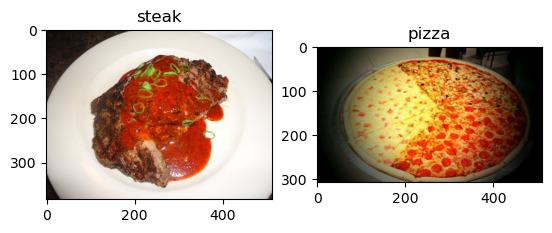

In [21]:
# Visualizing The Data:
plt.subplot(1,2,1)
steak_image= view_random_image("pizza_steak\\train\\", "steak")

plt.subplot(1,2,2)
pizza_image= view_random_image("pizza_steak\\train\\", "pizza")

### 2. Preprocess the data (prepare it for a model)

One of the most important steps for a machine learning project is creating a training and test set.

In our case, our data is already split into training and test sets. Another option here might be to create a validation set as well, but we'll leave that for now.

For an image classification project, it's standard to have your data seperated into `train` and `test` directories with subfolders in each for each class.

To start we define the training and test directory paths.

In [22]:
# Defining Training and Test Directory Path:

train_dir = "pizza_steak\\train\\"
test_dir = "pizza_steak\\test\\"

Our next step is to turn our data into **batches**.

A **batch** is a small subset of the dataset a model looks at during training. For example, rather than looking at 10,000 images at one time and trying to figure out the patterns, a model might only look at 32 images at a time.

It does this for a couple of reasons:
* 10,000 images (or more) might not fit into the memory of your processor (CPU or GPU).
* Trying to learn the patterns in 10,000 images in one hit could result in the model not being able to learn very well.

Why 32?

A [batch size of 32 is good for your health](https://twitter.com/ylecun/status/989610208497360896?s=20). 

32 has proven to be very effective in many different use cases and is often the default for many data preprocessing functions.

To turn our data into batches, we'll first create an instance of [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) for each of our datasets.

In [24]:
# Creating Training and Test Data Generator and Rescalling The Data:

train_datagen = ImageDataGenerator(rescale= 1/255)
test_datagen = ImageDataGenerator(rescale= 1/255)

The `ImageDataGenerator` class helps us prepare our images into batches as well as perform transformations on them as they get loaded into the model.

You might've noticed the `rescale` parameter. This is one example of the transformations we're doing.

Remember from before how we imported an image and it's pixel values were between 0 and 255?

The `rescale` parameter, along with `1/255.` is like saying "divide all of the pixel values by 255". This results in all of the image being imported and their pixel values being normalized (converted to be between 0 and 1).

For more transformation options such as data augmentation, refer to the [`ImageDataGenerator` documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).

Now we've got a couple of ImageDataGenerator instances, we can load our images from their respective directories using the [`flow_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory) method.

In [56]:
# Loading in Our Image Data from Directories and Turn them into Batches:

train_data = train_datagen.flow_from_directory(directory= train_dir,
                                              target_size= (224,224),
                                              class_mode= "binary",
                                              batch_size= 32)

test_data = test_datagen.flow_from_directory(directory= test_dir,
                                           target_size= (224,224),
                                           class_mode= "binary",
                                           batch_size= 32)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


Looks like our training dataset has 1500 images belonging to 2 classes (pizza and steak) and our test dataset has 500 images also belonging to 2 classes.

Some things to here:
* Due to how our directories are structured, the classes get inferred by the subdirectory names in `train_dir` and `test_dir`.
* The `target_size` parameter defines the input size of our images in `(height, width)` format.
* The `class_mode` value of `'binary'` defines our classification problem type. If we had more than two classes, we would use `'categorical'`.
* The `batch_size` defines how many images will be in each batch, we've used 32 which is the same as the default.

We can take a look at our batched images and labels by inspecting the `train_data` object.

In [46]:
images, label = next(train_data)

In [47]:
images.shape, label.shape

((32, 224, 224, 3), (32,))

In [48]:
images[0]

array([[[0.13725491, 0.14117648, 0.16078432],
        [0.16078432, 0.17254902, 0.19215688],
        [0.16470589, 0.1764706 , 0.20392159],
        ...,
        [0.12156864, 0.1254902 , 0.14117648],
        [0.12156864, 0.1254902 , 0.13333334],
        [0.13725491, 0.14509805, 0.14117648]],

       [[0.1254902 , 0.13725491, 0.17254902],
        [0.12941177, 0.14117648, 0.1764706 ],
        [0.14509805, 0.16078432, 0.20392159],
        ...,
        [0.10196079, 0.10588236, 0.12156864],
        [0.1137255 , 0.11764707, 0.1254902 ],
        [0.1254902 , 0.12941177, 0.13725491]],

       [[0.12156864, 0.13333334, 0.19215688],
        [0.1254902 , 0.13725491, 0.19607845],
        [0.14117648, 0.16470589, 0.227451  ],
        ...,
        [0.10196079, 0.10588236, 0.12156864],
        [0.10980393, 0.1137255 , 0.12156864],
        [0.10588236, 0.10980393, 0.11764707]],

       ...,

       [[0.12156864, 0.12941177, 0.08627451],
        [0.11764707, 0.1254902 , 0.08235294],
        [0.10588236, 0

In [49]:
label[0]

0.0

In [50]:
# Total Number of Batches:
len(train_data)

47

### 3. Create a model (start with a baseline)

A simple heuristic for computer vision models is to use the model architecture which is performing best on [ImageNet](https://www.image-net.org/) (a large collection of diverse images to benchmark different computer vision models).

However, to begin with, it's good to build a smaller model to acquire a baseline result which you try to improve upon.

In deep learning a smaller model often refers to a model with less layers than the state of the art (SOTA). For example, a smaller model might have 3-4 layers where as a state of the art model, such as, ResNet50 might have 50+ layers.

In our case, let's take a smaller version of the model that can be found on the [CNN explainer website](https://poloclub.github.io/cnn-explainer/) (`model_1` from above) and build a 3 layer convolutional neural network.

In [52]:
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Conv2D, MaxPool2D, Activation

In [66]:
# Building a Basic CNN:

tf.random.set_seed(42)

model_4 = Sequential()

model_4.add(InputLayer(shape=(224,224,3)))

model_4.add(Conv2D(filters= 10,
                  kernel_size= 3,
                  strides= 1,
                  padding= "valid",
                  activation= "relu"))

model_4.add(Conv2D(10, 3, activation= "relu"))

model_4.add(Conv2D(10, 3, activation= "relu"))

model_4.add(Flatten())

model_4.add(Dense(1, activation= "sigmoid"))

We've got a simple convolutional neural network architecture ready to go.

And it follows the typical CNN structure of:

```
Input -> Conv + ReLU layers (non-linearities) -> Pooling layer -> Fully connected (dense layer) as Output
```

Let's discuss some of the components of the `Conv2D` layer:

* The "`2D`" means our inputs are two dimensional (height and width), even though they have 3 colour channels, the convolutions are run on each channel invididually.
* `filters` - these are the number of "feature extractors" that will be moving over our images.
* `kernel_size` - the size of our filters, for example, a `kernel_size` of `(3, 3)` (or just 3) will mean each filter will have the size 3x3, meaning it will look at a space of 3x3 pixels each time. The smaller the kernel, the more fine-grained features it will extract.
* `stride` - the number of pixels a `filter` will move across as it covers the image. A `stride` of 1 means the filter moves across each pixel 1 by 1. A `stride` of 2 means it moves 2 pixels at a time.
* `padding` - this can be either `'same'` or `'valid'`, `'same'` adds zeros the to outside of the image so the resulting output of the convolutional layer is the same as the input, where as `'valid'` (default) cuts off excess pixels where the `filter` doesn't fit (e.g. 224 pixels wide divided by a kernel size of 3 (224/3 = 74.6) means a single pixel will get cut off the end.

What's a "feature"?

A **feature** can be considered any significant part of an image. For example, in our case, a feature might be the circular shape of pizza. Or the rough edges on the outside of a steak.

It's important to note that these **features** are not defined by us, instead, the model learns them as it applies different filters across the image.

For a great demonstration of these in action, be sure to spend some time going through the following:
  * [CNN Explainer Webpage](https://poloclub.github.io/cnn-explainer/) - a great visual overview of many of the concepts we're replicating here with code.
  * [A guide to convolutional arithmetic for deep learning](https://arxiv.org/pdf/1603.07285.pdf) - a phenomenal introduction to the math going on behind the scenes of a convolutional neural network.
  * For a great explanation of padding, see this [Stack Overflow answer](https://stackoverflow.com/a/39371113/7900723).


In [67]:
# Compiling The Model:

model_4.compile(optimizer= Adam(),
               loss= tf.keras.losses.BinaryCrossentropy,
               metrics= ["accuracy"])

In [68]:
model_4.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 222, 222, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 220, 220, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 218, 218, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 475240)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │       475,241 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 477,341 (1.82 MB)

 Trainable params: 477,341 (1.82 MB)

 Non-trainable params: 0 (0.00 B)

### 4. Fit the model

In [69]:
history_4 = model_4.fit(train_data,
           validation_data= test_data,
           epochs= 5)

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 187ms/step - accuracy: 0.5387 - loss: 2.6099 - val_accuracy: 0.7260 - val_loss: 0.5203
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - accuracy: 0.7793 - loss: 0.4717 - val_accuracy: 0.8020 - val_loss: 0.4482
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 190ms/step - accuracy: 0.9064 - loss: 0.2745 - val_accuracy: 0.8080 - val_loss: 0.4416
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - accuracy: 0.9585 - loss: 0.1345 - val_accuracy: 0.8140 - val_loss: 0.4625
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - accuracy: 0.9951 - loss: 0.0460 - val_accuracy: 0.8060 - val_loss: 0.5174


### 5. Evaluate the model

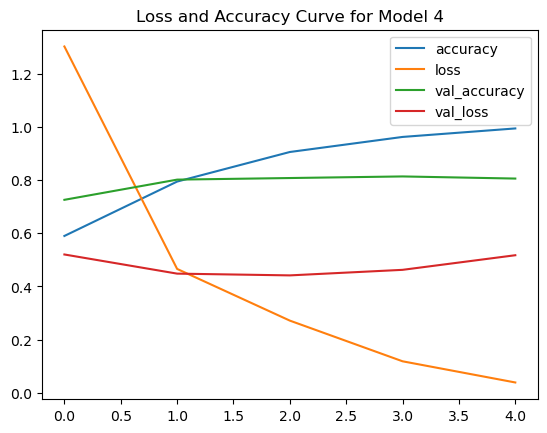

In [70]:
# Plotting The Loss and Accuracy Curve of Model:

pd.DataFrame(history_4.history).plot(title="Loss and Accuracy Curve for Model 4")
plt.show()

Judging by our loss curves, it looks like our model is **overfitting** the training dataset.

When a model's **validation loss starts to increase**, it's likely that it's overfitting the training dataset. This means, it's learning the patterns in the training dataset *too well* and thus its ability to generalize to unseen data will be diminished.

To further inspect our model's training performance, let's separate the accuracy and loss curves.

In [71]:
# Creating a Function to plot Training and Validtion Loss and Accuracy
# Curves Seperately:

def plot_loss_curves(history):
    
    """
    Returns Seperate Loss Curves for Training and Validation Metrics.
    """
    
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    
    epochs = range(len(history.history["loss"]))
    
    # Plotting Loss Curve:
    plt.plot(epochs, loss, label= "Training Loss")
    plt.plot(epochs, val_loss, label= "Validation Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    # Plotting Accuracy Curve:
    plt.plot(epochs, accuracy, label= "Training Accuracy")
    plt.plot(epochs, val_accuracy, label= "Validation Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

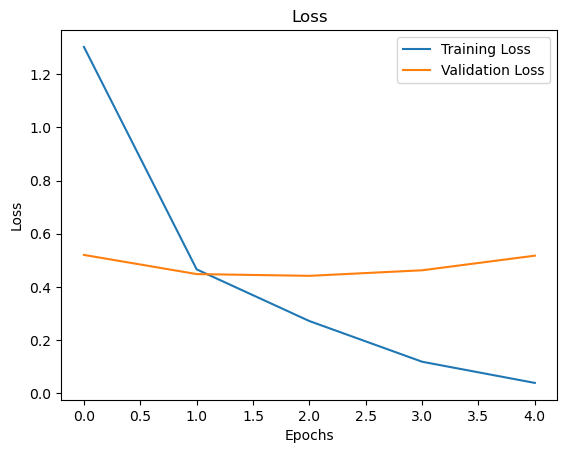

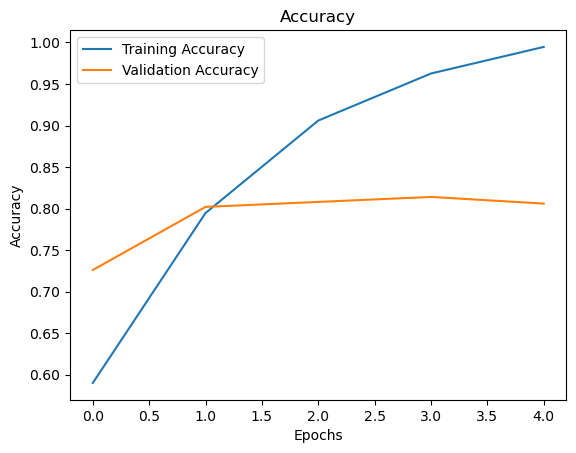

In [72]:
# Loss Curves for Model_4:
plot_loss_curves(history_4)

The ideal position for these two curves is to follow each other. If anything, the validation curve should be slightly under the training curve. If there's a large gap between the training curve and validation curve, it means your model is probably overfitting.

In [73]:
model_4.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 222, 222, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 220, 220, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 218, 218, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 475240)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │       475,241 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,432,025 (5.46 MB)

 Trainable params: 477,341 (1.82 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 954,684 (3.64 MB)

### 6. Adjust the model parameters

Fitting a machine learning model  comes in 3 steps:
0. Create a basline.
1. Beat the baseline by overfitting a larger model.
2. Reduce overfitting.

So far we've gone through steps 0 and 1.

And there are even a few more things we could try to further overfit our model:
* Increase the number of convolutional layers.
* Increase the number of convolutional filters.
* Add another dense layer to the output of our flattened layer.

But what we'll do instead is focus on getting our model's training curves to better align with eachother, in other words, we'll take on step 2.

Why is reducing overfitting important?

When a model performs too well on training data and poorly on unseen data, it's not much use to us if we wanted to use it in the real world.

Say we were building a pizza vs. steak food classifier app, and our model performs very well on our training data but when users tried it out, they didn't get very good results on their own food images, is that a good experience?

So for the next few models we build, we're going to adjust a number of parameters and inspect the training curves along the way.

Namely, we'll build 2 more models:
* A ConvNet with [max pooling](https://deeplizard.com/learn/video/ZjM_XQa5s6s)
* A ConvNet with max pooling and data augmentation

For the first model, we'll follow the modified basic CNN structure:

```
Input -> Conv layers + ReLU layers (non-linearities) + Max Pooling layers -> Fully connected (dense layer) as Output
```

Let's built it. It'll have the same structure as `model_4` but with a [`MaxPool2D()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layer after each convolutional layer.


In [75]:
# Creating a CNN with Maxpool2D Layer:

tf.random.set_seed(42)

model_5 = Sequential()

model_5.add(InputLayer(shape= (224,224,3)))

model_5.add(Conv2D(filters=10,
                  kernel_size=3,
                  activation= "relu"))
model_5.add(MaxPool2D(pool_size= 2))

model_5.add(Conv2D(10, 3, activation= "relu"))
model_5.add(MaxPool2D(pool_size= 2))

model_5.add(Conv2D(10, 3, activation= "relu"))
model_5.add(MaxPool2D(pool_size= 2))

model_5.add(Flatten())

model_5.add(Dense(1, activation= "sigmoid"))

If convolutional layers learn the features of an image you can think of a Max Pooling layer as figuring out the *most important* of those features.

In [76]:
# Compiling The Model:

model_5.compile(optimizer= Adam(),
               loss= tf.keras.losses.BinaryCrossentropy,
               metrics= ["accuracy"])

In [77]:
# Fit The Model:

history_5 = model_5.fit(train_data,
                       validation_data= test_data,
                       epochs= 5)

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.6083 - loss: 0.6655 - val_accuracy: 0.7880 - val_loss: 0.4617
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - accuracy: 0.7756 - loss: 0.4667 - val_accuracy: 0.8540 - val_loss: 0.3471
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - accuracy: 0.8298 - loss: 0.3937 - val_accuracy: 0.8760 - val_loss: 0.3330
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 0.8331 - loss: 0.3773 - val_accuracy: 0.8740 - val_loss: 0.3368
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 0.8321 - loss: 0.3817 - val_accuracy: 0.8880 - val_loss: 0.3089


It looks like our model with max pooling (`model_5`) is performing worse on the training set but better on the validation set.

In [78]:
model_5.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 222, 222, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 111, 111, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 109, 109, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 54, 54, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 52, 52, 10)     │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 26, 26, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 6760)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │         6,761 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,585 (103.85 KB)

 Trainable params: 8,861 (34.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,724 (69.24 KB)

Do you notice what's going on here with the output shape in each `MaxPooling2D` layer?

It gets halved each time. This is effectively the `MaxPooling2D` layer taking the outputs of each Conv2D layer and saying "I only want the most important features, get rid of the rest".

The bigger the `pool_size` parameter, the more the max pooling layer will squeeze the features out of the image. However, too big and the model might not be able to learn anything.

The results of this pooling are seen in a major reduction of total trainable parameters (8,861 in `model_5` and 477,431 in `model_4`).

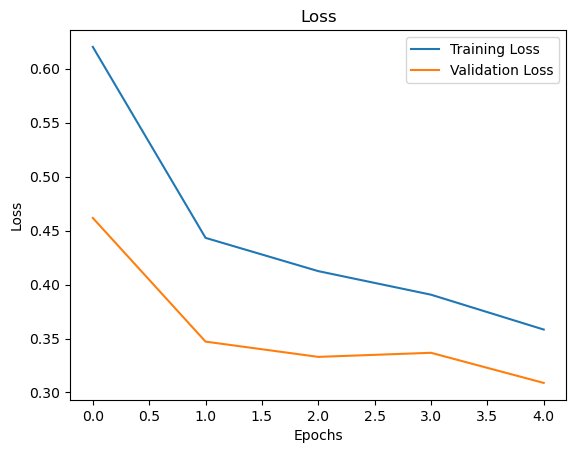

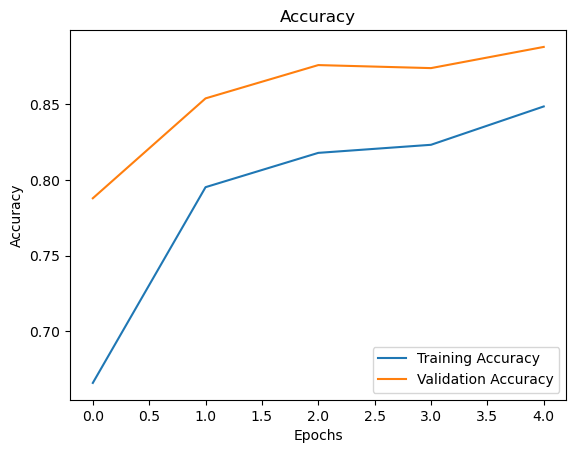

In [79]:
# Plotting Loss and Accuracy Curves:
plot_loss_curves(history_5)

Time to try another method of overfitting prevention, data augmentation.

To implement data augmentation, we'll have to reinstantiate our [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) instances.

In [80]:
# Creating ImageDataGenerator training instance with Data Augmentation:

train_datagen_augmentated = ImageDataGenerator(rescale= 1/255,
                                              rotation_range= 20, # rotate the image slightly between 0 and 20 degrees
                                              shear_range= 0.2, # shear the image
                                              zoom_range= 0.2, # zoom into the image
                                              width_shift_range= 0.2, # shift the image width ways
                                              height_shift_range= 0.2, # shift the image height ways
                                              horizontal_flip= True) # flip the image on the horizontal axis

# Create Image Data Generator Without Data Augmentation:
train_datagen = ImageDataGenerator(rescale= 1/255)

# Create Image Data Generator for Test Data Without Data Augmentation:
test_datagen = ImageDataGenerator(rescale= 1/255)

 What's data augmentation?

**Data augmentation** is the process of altering our training data, leading to it having more diversity and in turn allowing our models to learn more generalizable patterns. Altering might mean adjusting the rotation of an image, flipping it, cropping it or something similar.

Doing this simulates the kind of data a model might be used on in the real world.

If we're building a pizza vs. steak application, not all of the images our users take might be in similar setups to our training data. Using data augmentation gives us another way to prevent overfitting and in turn make our model more generalizable.

Data augmentation is usally only performed on the training data. Using the `ImageDataGenerator` built-in data augmentation parameters our images are left as they are in the directories but are randomly manipulated when loaded into the model.

In [81]:
# Import Data from Trainig Directory and Augment it:

train_data_augmented = train_datagen_augmentated.flow_from_directory(train_dir,
                                                target_size= (224,224),
                                                batch_size= 32,
                                                class_mode= "binary",
                                                shuffle= False)

# Create Non-Augmented Data Batches from Trainig Directory:
train_data = train_datagen.flow_from_directory(train_dir,
                                              target_size=(224,224),
                                              batch_size= 32,
                                              class_mode= "binary",
                                              shuffle= False)

# Create Non-Augmented Data Batches from Testing Directory:
test_data = test_datagen.flow_from_directory(test_dir,
                                            target_size= (224,224),
                                            batch_size= 32,
                                            class_mode= "binary")

Found 1500 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [82]:
# Getting a Sample Batches from Augmented and Non-Augmented Training Data:

images, labels = next(train_data)
images_aug, labels_aug = next(train_data_augmented)

In [83]:
images.shape, images_aug.shape

((32, 224, 224, 3), (32, 224, 224, 3))

In [84]:
len(images), len(images_aug)

(32, 32)

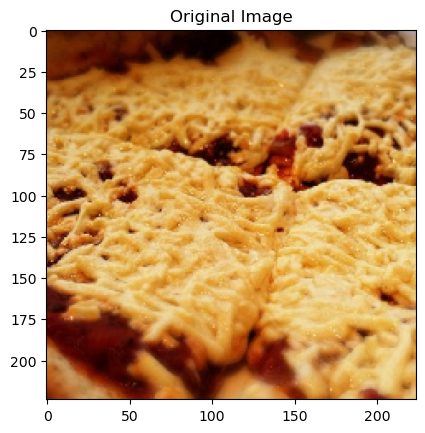

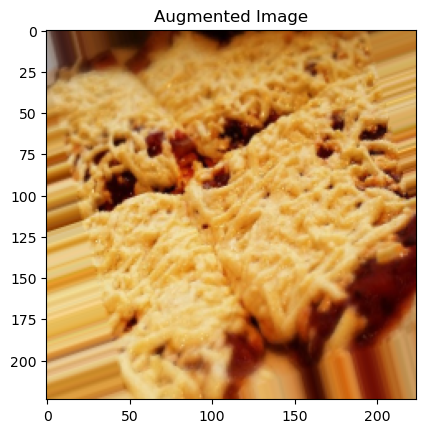

In [96]:
# Visualizing Random Image and It's Augmented Version:

random_number = random.randint(0,31)

plt.imshow(images[random_number])
plt.title("Original Image")
plt.show()

plt.imshow(images_aug[random_number])
plt.title("Augmented Image")
plt.show()

After going through a sample of original and augmented images, we can start to see some of the example transformations on the training images.

Notice how some of the augmented images look like slightly warped versions of the original image. This means our model will be forced to try and learn patterns in less-than-perfect images, which is often the case when using real-world images.

Should we use data augmentation? And how much should we augment?

Data augmentation is a way to try and prevent a model overfitting. If your model is overfiting (e.g. the validation loss keeps increasing), you may want to try using data augmentation.

As for how much to data augment, there's no set practice for this. Best to check out the options in the `ImageDataGenerator` class and think about how a model in your use case might benefit from some data augmentation.

In [98]:
# Creating a Model on Augmented Data:

tf.random.set_seed(42)

model_6 = Sequential()

model_6.add(InputLayer(shape= (224,224,3)))

model_6.add(Conv2D(filters=10,
                  kernel_size=2,
                  activation= "relu"))
model_6.add(MaxPool2D(pool_size=2))

model_6.add(Conv2D(10, 3, activation= "relu"))
model_6.add(MaxPool2D(pool_size= 2))

model_6.add(Conv2D(10, 3, activation= "relu"))
model_6.add(MaxPool2D(pool_size= 2))

model_6.add(Flatten())

model_6.add(Dense(1, activation= "sigmoid"))

model_6.compile(optimizer= Adam(),
               loss= tf.keras.losses.BinaryCrossentropy,
               metrics= ["accuracy"])

history_6= model_6.fit(train_data_augmented,
           validation_data= test_data,
           epochs= 5)

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 41s 712ms/step - accuracy: 0.4154 - loss: 0.7771 - val_accuracy: 0.5320 - val_loss: 0.6905
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 35s 653ms/step - accuracy: 0.6022 - loss: 0.6904 - val_accuracy: 0.6880 - val_loss: 0.6640
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 38s 682ms/step - accuracy: 0.6791 - loss: 0.6687 - val_accuracy: 0.7820 - val_loss: 0.5194
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 38s 686ms/step - accuracy: 0.6638 - loss: 0.6441 - val_accuracy: 0.6540 - val_loss: 0.5776
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 33s 606ms/step - accuracy: 0.6876 - loss: 0.5608 - val_accuracy: 0.7680 - val_loss: 0.4830


Why didn't our model get very good results on the training set to begin with?

It's because when we created `train_data_augmented` we turned off data shuffling using `shuffle=False` which means our model only sees a batch of a single kind of images at a time. 

For example, the pizza class gets loaded in first because it's the first class. Thus it's performance is measured on only a single class rather than both classes. The validation data performance improves steadily because it contains shuffled data.

Since we only set `shuffle=False` for demonstration purposes (so we could plot the same augmented and non-augmented image), we can fix this by setting `shuffle=True` on future data generators.

You may have also noticed each epoch taking longer when training with augmented data compared to when training with non-augmented data (~25s per epoch vs. ~10s per epoch).

This is because the `ImageDataGenerator` instance augments the data as it's loaded into the model. The benefit of this is that it leaves the original images unchanged. The downside is that it takes longer to load them in.

One possible method to speed up dataset manipulation would be to look into [TensorFlow's parrallel reads and buffered prefecting options](https://www.tensorflow.org/tutorials/images/data_augmentation).

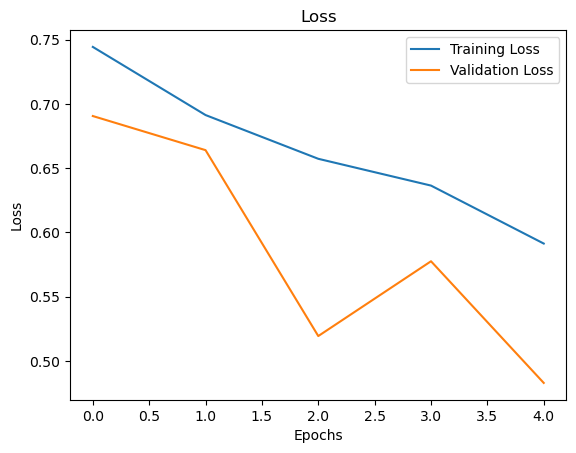

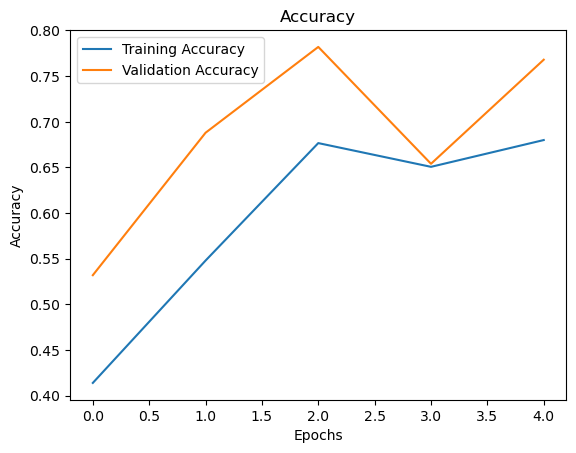

In [99]:
# Plotting Loss and Accuracy Curves:

plot_loss_curves(history_6)

Let's see what happens when we shuffle the augmented training data.

In [100]:
# Importing Data From Training Directory, Augmenting it and Shuffling it:

train_data_augmented_shuffled = train_datagen_augmentated.flow_from_directory(
                                                        train_dir,
                                                        target_size= (224,224),
                                                        class_mode= "binary",
                                                        batch_size= 32,
                                                        shuffle= True)

Found 1500 images belonging to 2 classes.


In [101]:
# Creating CNN (Same as model_5 and model_6)

tf.random.set_seed(42)

model_7 = Sequential()

model_7.add(InputLayer(shape= (224,224,3)))

model_7.add(Conv2D(filters= 10,
                  kernel_size= 2,
                  activation= "relu"))
model_7.add(MaxPool2D(pool_size= 2))

model_7.add(Conv2D(10, 3, activation= "relu"))
model_7.add(MaxPool2D(pool_size= 2))

model_7.add(Conv2D(10, 3, activation= "relu"))
model_7.add(MaxPool2D(pool_size= 2))

model_7.add(Flatten())

model_7.add(Dense(1, activation= "sigmoid"))

model_7.compile(optimizer= Adam(),
               loss= tf.keras.losses.BinaryCrossentropy,
               metrics= ["accuracy"])

history_7 = model_7.fit(train_data_augmented_shuffled,
            validation_data= test_data,
            epochs= 5)


Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 40s 686ms/step - accuracy: 0.5598 - loss: 0.6814 - val_accuracy: 0.7680 - val_loss: 0.5129
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 37s 692ms/step - accuracy: 0.7028 - loss: 0.5718 - val_accuracy: 0.7720 - val_loss: 0.4797
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 38s 699ms/step - accuracy: 0.7562 - loss: 0.5652 - val_accuracy: 0.8100 - val_loss: 0.4262
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 36s 641ms/step - accuracy: 0.7538 - loss: 0.5142 - val_accuracy: 0.7740 - val_loss: 0.4677
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 35s 636ms/step - accuracy: 0.7854 - loss: 0.4959 - val_accuracy: 0.8640 - val_loss: 0.3704


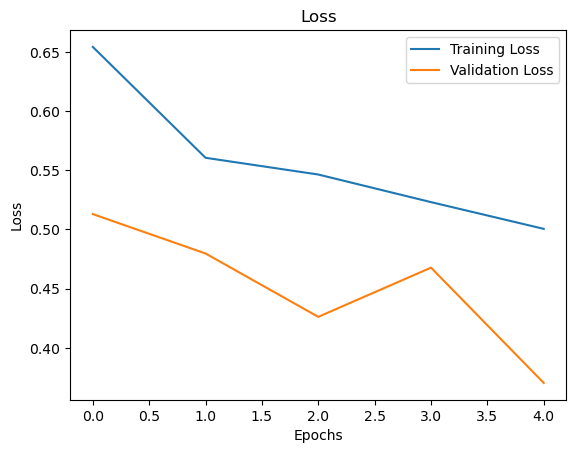

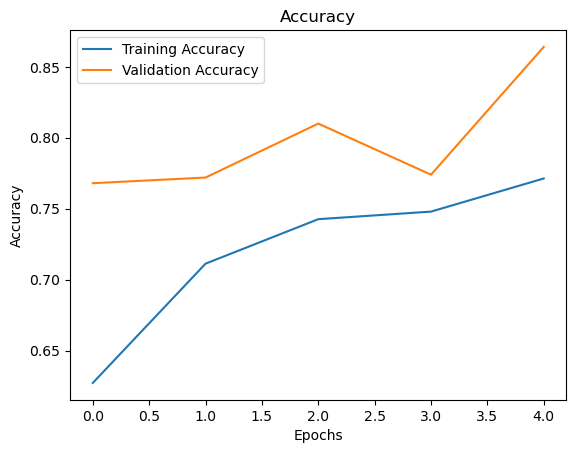

In [102]:
# Plotting Loss and Accuracy Curves:
plot_loss_curves(history_7)

Notice with `model_7` how the performance on the training dataset improves almost immediately compared to `model_6`. This is because we shuffled the training data as we passed it to the model using the parameter `shuffle=True` in the `flow_from_directory` method.

This means the model was able to see examples of both pizza and steak images in each batch and in turn be evaluated on what it learned from both images rather than just one kind.

Also, our loss curves look a little bit smoother with shuffled data (comparing `history_6` to `history_7`).

### 7. Repeat until satisified

We've trained a few model's on our dataset already and so far they're performing pretty good.

Since we've already beaten our baseline, there are a few things we could try to continue to improve our model:
* Increase the number of model layers (e.g. add more convolutional layers).
* Increase the number of filters in each convolutional layer (e.g. from 10 to 32, 64, or 128, these numbers aren't set in stone either, they are usually found through trial and error).
* Train for longer (more epochs).
* Finding an ideal learning rate.
* Get more data (give the model more opportunities to learn).
* Use **transfer learning** to leverage what another image model has learned and adjust it for our own use case.

Adjusting each of these settings (except for the last two) during model development is usually referred to as **hyperparameter tuning**.

You can think of hyperparameter tuning as simialr to adjusting the settings on your oven to cook your favourite dish. Although your oven does most of the cooking for you, you can help it by tweaking the dials.

Let's go back to right where we started and try our original model (`model_1`).

In [103]:
# Creatinf Same Model as model_1, for longer training:

tf.random.set_seed(42)

model_8 = Sequential()

model_8.add(InputLayer(shape= (224,224,3)))

model_8.add(Conv2D(filters=10,
                  kernel_size=2,
                  activation= "relu"))
model_8.add(Conv2D(10, 3, activation= "relu"))
model_8.add(MaxPool2D(pool_size=2))

model_8.add(Conv2D(10, 3, activation= "relu"))
model_8.add(Conv2D(10, 3, activation= "relu"))
model_8.add(MaxPool2D(pool_size= 2))

model_8.add(Flatten())

model_8.add(Dense(1, activation= "sigmoid"))

model_8.compile(optimizer= Adam(),
               loss= tf.keras.losses.BinaryCrossentropy,
               metrics= ["accuracy"])

history_8 = model_8.fit(train_data_augmented_shuffled,
                       validation_data= test_data,
                       epochs= 10)

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 39s 678ms/step - accuracy: 0.5040 - loss: 0.7460 - val_accuracy: 0.6920 - val_loss: 0.6672
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 33s 612ms/step - accuracy: 0.6501 - loss: 0.6568 - val_accuracy: 0.7680 - val_loss: 0.5086
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 34s 629ms/step - accuracy: 0.7187 - loss: 0.5422 - val_accuracy: 0.8180 - val_loss: 0.4334
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 37s 669ms/step - accuracy: 0.7460 - loss: 0.5303 - val_accuracy: 0.7720 - val_loss: 0.4448
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 41s 753ms/step - accuracy: 0.7614 - loss: 0.5027 - val_accuracy: 0.8440 - val_loss: 0.3591
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 39s 710ms/step - accuracy: 0.7834 - loss: 0.4818 - val_accuracy: 0.8620 - val_loss: 0.3315
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 40s 729ms/step - accuracy: 0.8015 - loss: 0.4559 - val_accuracy: 0.8560 - val_loss: 0.3315
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 38s 697ms/step - accuracy: 0.8245 - loss: 0.4064 - val_accu

In [104]:
model_8.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 223, 223, 10)   │           130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 221, 221, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 110, 110, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 108, 108, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 106, 106, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 53, 53, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 28090)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │        28,091 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,855 (362.72 KB)

 Trainable params: 30,951 (120.90 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,904 (241.82 KB)

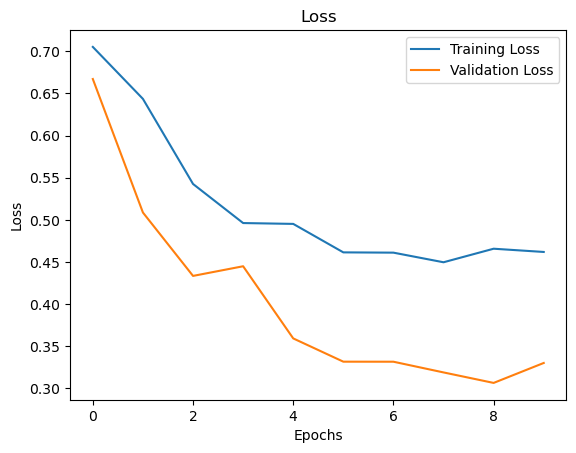

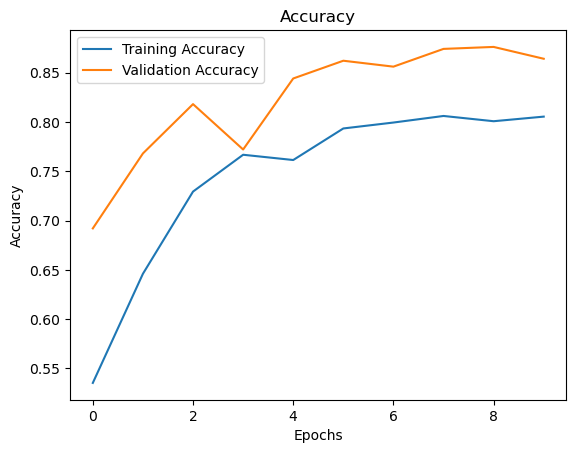

In [105]:
# Plotting Loss and Accuracy Curves:
plot_loss_curves(history_8)

### Making a prediction with our trained model

In [108]:
# Take Some Images from Train / Test  Folders and put it into same directory
# Jupyter Notebook is running on.

os.getcwd()

'C:\\Users\\shail'

In [115]:
# Creating a Function to Load Image and Preprocess it for Model Prediction:

def load_and_prep_image(file_name, image_shape = 224):
    
    """
    Reads an Image from file_name, turns it into a Tensor and
    Reshapes it to size (image_shape, image_shape, color_channel)
    """
    
    # Reading in File:
    img = tf.io.read_file(file_name)
    
    # Decode the read file into Tensor:
    img = tf.image.decode_image(img, channels= 3)
    
    # Resize the image
    img = tf.image.resize(img, size=(image_shape,image_shape))
    
    # Rescalling the Image:
    img = img / 255
    
    # Expanding The Image Dimensions to Include Batch Size in Dimension as
    # Our Model Expects:
    img = tf.expand_dims(img, axis= 0)
                          
    return img

In [121]:
# Loading and Pre-processing an Image:
pizza = load_and_prep_image("p2.jpg")

In [122]:
type(pizza)

tensorflow.python.framework.ops.EagerTensor

In [123]:
pizza

<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[0.09894583, 0.08325955, 0.        ],
         [0.11270383, 0.09701756, 0.        ],
         [0.13725364, 0.11204357, 0.02829007],
         ...,
         [0.1355744 , 0.10896367, 0.00868339],
         [0.15742308, 0.11820739, 0.02016817],
         [0.16953415, 0.13031846, 0.03227925]],

        [[0.09678496, 0.07717712, 0.        ],
         [0.11710309, 0.09357368, 0.00729917],
         [0.13941827, 0.11420818, 0.02877401],
         ...,
         [0.13954474, 0.11293401, 0.01265372],
         [0.1571429 , 0.11792722, 0.01988801],
         [0.16447829, 0.1252626 , 0.02722339]],

        [[0.10022885, 0.080621  , 0.00192452],
         [0.11180722, 0.08827781, 0.0020033 ],
         [0.12762605, 0.09771159, 0.0146296 ],
         ...,
         [0.14803442, 0.11308405, 0.01579746],
         [0.15992273, 0.11471965, 0.01368674],
         [0.163778  , 0.11857492, 0.01754202]],

        ...,

        [[0.01568628, 0.01176471, 

In [124]:
# Predicting Label of Image Using Model:
model_8.predict(pizza)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


array([[0.08110233]], dtype=float32)

In [125]:
class_names

array(['pizza', 'steak'], dtype='<U5')

The predictions come out in **prediction probability** form. In other words, this means how likely the image is to be one class or another.

Since we're working with a binary classification problem, if the prediction probability is over 0.5, according to the model, the prediction is most likely to be the **postive class** (class 1).

And if the prediction probability is under 0.5, according to the model, the predicted class is most likely to be the **negative class** (class 0).

The 0.5 cutoff can be adjusted to your liking. For example, you could set the limit to be 0.8 and over for the positive class and 0.2 for the negative class. However, doing this will almost always change your model's performance metrics so be sure to make sure they change in the right direction.

But saying positive and negative class doesn't make much sense when we're working with pizza and steak.

In [131]:
# Indexing the class name by rounding prediction probability to nearest integer.

pred_prob = model_8.predict(pizza) 
pred_class = class_names[int(tf.round(pred_prob)[0][0])]
pred_class

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


'pizza'

In [142]:
# Creating a Function to Read an Image, make a prediction of it's label using
# The Model and Plot Image with Predicted Label

def plot_and_predict(model, filename, class_names):
    
    """
    Imports an image located at filename, makes a prediction on it with
    a trained model and plots the image with the predicted class as the title
    """
    
    # Reading in The Image and Pre-Processing it
    img = load_and_prep_image(filename)
    
    # Make a Prediction using Trained Model:
    pred_prob = model.predict(img)
    
    # Get The name of Predicted Class:
    pred_class = class_names[int(tf.round(pred_prob)[0][0])]
    
    # Plot The Image and Predicted Class:
    plt.imshow(tf.squeeze(img))
    plt.title(f" Prediction: {pred_class}")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


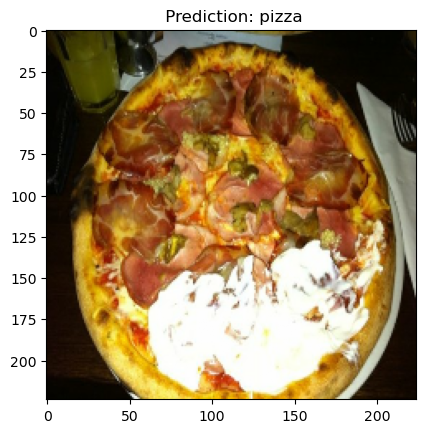

In [143]:
# Testing The Model:
plot_and_predict(model_8, "p2.jpg", class_names)

## Multi-class Classification


1. Become one with the data (visualize)
2. Preprocess the data (prepare it for a model)
3. Create a model (start with a baseline)
4. Fit the model
5. Evaluate the model
6. Adjust different parameters and improve model (try to beat your baseline)
7. Repeat until satisfied

### 1. Import The Data

We've got a subset of the Food101 dataset. In addition to the pizza and steak images, we've pulled out another eight classes.

In [146]:
import os

# Walkthrough The Directory:
for dirpath, dirname, filename in os.walk("food_10_classes"):
    print(f"There are {len(dirname)} Directories and {len(filename)} Images in {dirpath}")

There are 2 Directories and 0 Images in food_10_classes
There are 10 Directories and 0 Images in food_10_classes\test
There are 0 Directories and 250 Images in food_10_classes\test\chicken_curry
There are 0 Directories and 250 Images in food_10_classes\test\chicken_wings
There are 0 Directories and 250 Images in food_10_classes\test\fried_rice
There are 0 Directories and 250 Images in food_10_classes\test\grilled_salmon
There are 0 Directories and 250 Images in food_10_classes\test\hamburger
There are 0 Directories and 250 Images in food_10_classes\test\ice_cream
There are 0 Directories and 250 Images in food_10_classes\test\pizza
There are 0 Directories and 250 Images in food_10_classes\test\ramen
There are 0 Directories and 250 Images in food_10_classes\test\steak
There are 0 Directories and 250 Images in food_10_classes\test\sushi
There are 10 Directories and 0 Images in food_10_classes\train
There are 0 Directories and 750 Images in food_10_classes\train\chicken_curry
There are 0 D

In [147]:
# Creating Training and Test Directory Paths:
train_dir = "food_10_classes\\train\\"
test_dir = "food_10_classes\\test\\"

In [148]:
# getting Class Names:
import pathlib
import numpy as np

data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


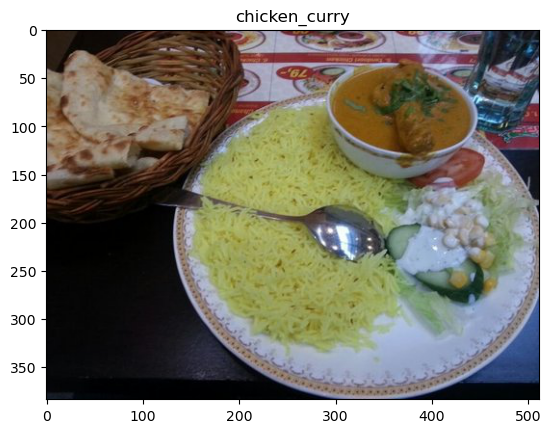

In [153]:
# Viewing An Random Image:
img = view_random_image(train_dir, random.choice(class_names))

### 2. Preprocess the data (prepare it for a model)

After going through a handful of images (it's good to visualize at least 10-100 different examples), it looks like our data directories are setup correctly.

Time to preprocess the data.

In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

In [158]:
# Creating Image Data Generators for Training and Test Data:

train_datagen = ImageDataGenerator(rescale= 1/255)
test_datagen = ImageDataGenerator(rescale= 1/255)

# Load Data From Training and Test Directories and Turn them into Batches:

train_data = train_datagen.flow_from_directory(train_dir,
                                              target_size= (224,224),
                                              batch_size= 32,
                                              class_mode= "categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                         target_size=(224,224),
                                            batch_size= 32,
                                            class_mode= "categorical")

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


### 3. Create a model (start with a baseline)

We can use the same model we used for the binary classification problem for our multi-class classification problem with a couple of small tweaks.

Namely:
* Changing the output layer to use have 10 ouput neurons (the same number as the number of classes we have).
* Changing the output layer to use `'softmax'` activation instead of `'sigmoid'` activation.
* Changing the loss function to be `'categorical_crossentropy'` instead of `'binary_crossentropy'`.

In [161]:
# Create a Baseline Model:

tf.random.set_seed(42)

model_9 = Sequential()

model_9.add(InputLayer(shape= (224,224,3)))

model_9.add(Conv2D(10, 3, activation= "relu"))
model_9.add(Conv2D(10, 3, activation= "relu"))
model_9.add(MaxPool2D(pool_size= 2))

model_9.add(Conv2D(10, 3, activation= "relu"))
model_9.add(Conv2D(10, 3, activation= "relu"))
model_9.add(MaxPool2D(pool_size= 2))

model_9.add(Flatten())

model_9.add(Dense(10, activation= "softmax"))

model_9.compile(optimizer= Adam(),
               loss= CategoricalCrossentropy,
               metrics= ["accuracy"])

In [162]:
model_9.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_29 (Conv2D)              │ (None, 222, 222, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 220, 220, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 110, 110, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 108, 108, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 106, 106, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 53, 53, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 28090)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │       280,910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 283,920 (1.08 MB)

 Trainable params: 283,920 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

In [164]:
# Fitting The Model:

history_9 = model_9.fit(train_data,
            validation_data= test_data,
            epochs= 5)

Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 57s 240ms/step - accuracy: 0.3196 - loss: 1.9414 - val_accuracy: 0.3384 - val_loss: 1.8988
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 43s 178ms/step - accuracy: 0.4036 - loss: 1.7707 - val_accuracy: 0.3404 - val_loss: 1.9192
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 42s 174ms/step - accuracy: 0.4874 - loss: 1.5113 - val_accuracy: 0.3420 - val_loss: 1.9585
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 43s 179ms/step - accuracy: 0.6686 - loss: 1.0442 - val_accuracy: 0.3172 - val_loss: 2.2201
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 43s 179ms/step - accuracy: 0.8379 - loss: 0.5377 - val_accuracy: 0.2868 - val_loss: 2.9510


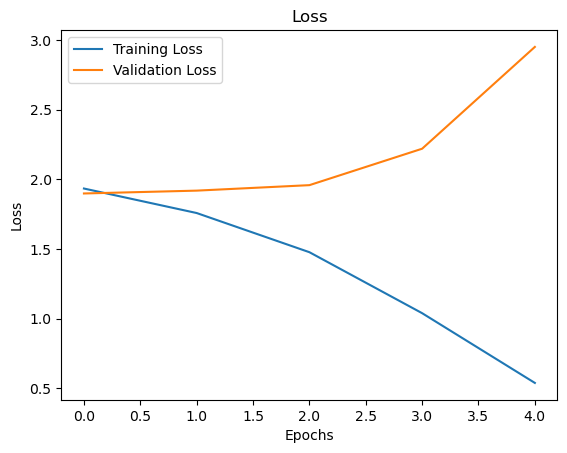

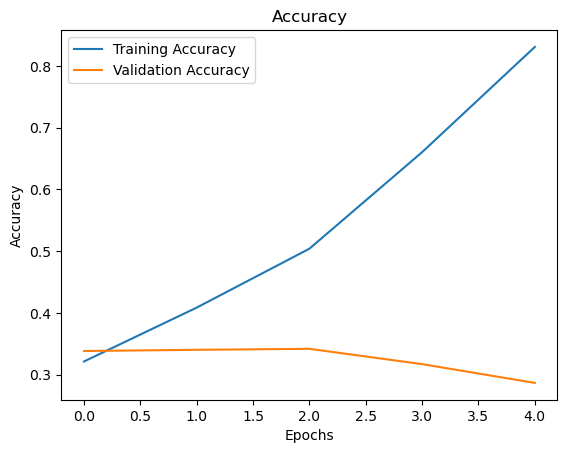

In [165]:
# Checking Loss Curves:
plot_loss_curves(history_9)

It seems our model is **overfitting** the training set quite badly. In other words, it's getting great results on the training data but fails to generalize well to unseen data and performs poorly on the test data.

### 6. Adjust the model parameters

Due to its performance on the training data, it's clear our model is learning something. However, performing well on the training data is like going well in the classroom but failing to use your skills in real life.

Ideally, we'd like our model to perform as well on the test data as it does on the training data.

So our next steps will be to try and prevent our model overfitting. A couple of ways to prevent overfitting include:

- **Get more data** - Having more data gives the model more opportunities to learn patterns, patterns which may be more generalizable to new examples.
- **Simplify model** - If the current model is already overfitting the training data, it may be too complicated of a model. This means it's learning the patterns of the data too well and isn't able to generalize well to unseen data. One way to simplify a model is to reduce the number of layers it uses or to reduce the number of hidden units in each layer.
- **Use data augmentation** - Data augmentation manipulates the training data in a way so that's harder for the model to learn as it artificially adds more variety to the data. If a model is able to learn patterns in augmented data, the model may be able to generalize better to unseen data.
- **Use transfer learning** - Transfer learning involves leverages the patterns (also called pretrained weights) one model has learned to use as the foundation for your own task. In our case, we could use one computer vision model pretrained on a large variety of images and then tweak it slightly to be more specialized for food images.

Preventing overfitting is also referred to as **regularization**.

If you've already got an existing dataset, you're probably most likely to try one or a combination of the last three above options first.

In [166]:
# Simplifying The Model by Removing 2 Convolution Layers:

tf.random.set_seed(42)

model_10 = Sequential()

model_10.add(InputLayer(shape= (224,224,3)))

model_10.add(Conv2D(10, 3, activation= "relu"))
model_10.add(MaxPool2D(pool_size= 2))

model_10.add(Conv2D(10, 3, activation= "relu"))
model_10.add(MaxPool2D(pool_size= 2))

model_10.add(Flatten())

model_10.add(Dense(10, activation= "softmax"))

model_10.compile(optimizer= Adam(),
                loss= CategoricalCrossentropy,
                metrics= ["accuracy"])

history_10 = model_10.fit(train_data,
                         validation_data= test_data,
                         epochs= 5)

Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 166ms/step - accuracy: 0.1630 - loss: 2.6636 - val_accuracy: 0.2452 - val_loss: 2.0434
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 39s 163ms/step - accuracy: 0.3106 - loss: 1.9655 - val_accuracy: 0.3008 - val_loss: 1.9573
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 39s 161ms/step - accuracy: 0.4503 - loss: 1.6478 - val_accuracy: 0.3404 - val_loss: 1.9221
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 38s 160ms/step - accuracy: 0.6310 - loss: 1.1757 - val_accuracy: 0.3188 - val_loss: 2.1581
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 40s 164ms/step - accuracy: 0.8002 - loss: 0.6914 - val_accuracy: 0.3092 - val_loss: 2.4014


In [167]:
model_10.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)              │ (None, 222, 222, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 111, 111, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 109, 109, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 54, 54, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 29160)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 10)             │       291,610 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 878,402 (3.35 MB)

 Trainable params: 292,800 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 585,602 (2.23 MB)

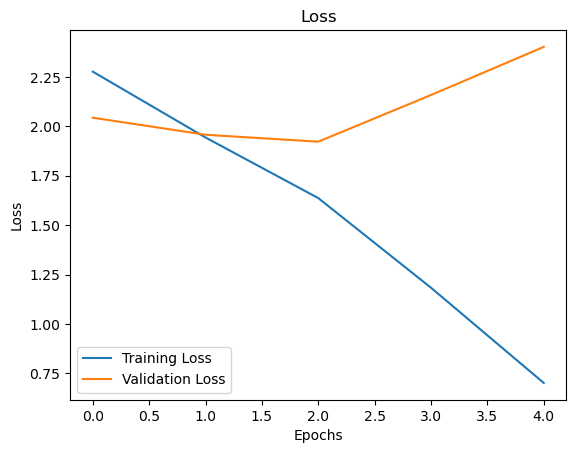

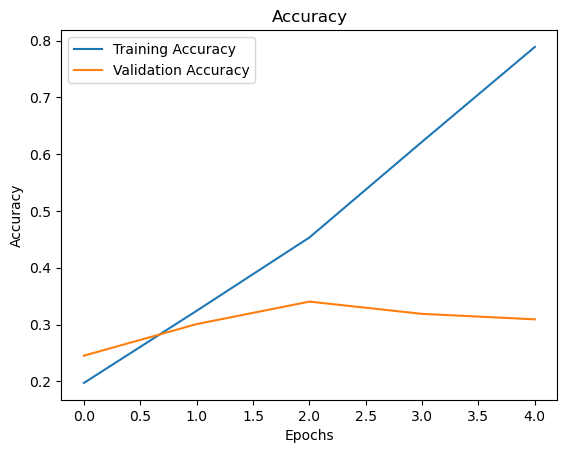

In [168]:
# Plotting Loss and Accuracy Curves:
plot_loss_curves(history_10)

Even with a simplifed model, it looks like our model is still dramatically overfitting the training data.

What else could we try?

How about **data augmentation**?

Data augmentation makes it harder for the model to learn on the training data and in turn, hopefully making the patterns it learns more generalizable to unseen data.

To create augmented data, we'll recreate a new [`ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) instance, this time adding some parameters such as `rotation_range` and `horizontal_flip` to manipulate our images.

In [169]:
# Createing Augmented Data Generator for training Data:

train_datagen_augmented = ImageDataGenerator(rescale= 1/255,
                                            rotation_range= 20,
                                            width_shift_range= 0.2,
                                            height_shift_range= 0.2,
                                            zoom_range= 0.2,
                                            horizontal_flip= True)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                    target_size=(224,224),
                                                    batch_size= 32,
                                                    class_mode= "categorical")

Found 7500 images belonging to 10 classes.


Now we've got augmented data, let's see how it works with the same model as before (`model_9`).

Rather than rewrite the model from scratch, we can clone it using a handy function in TensorFlow called [`clone_model`](https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model) which can take an existing model and rebuild it in the same format. 

The cloned version will not include any of the weights (patterns) the original model has learned. So when we train it, it'll be like training a model from scratch.

One of the key practices in deep learning and machine learning in general is to **be a serial experimenter**. That's what we're doing here. Trying something, seeing if it works, then trying something else. A good experiment setup also keeps track of the things you change, for example, that's why we're using the same model as before but with different data. The model stays the same but the data changes, this will let us know if augmented training data has any influence over performance.

In [172]:
# Clone The Last MOdel to Create New Model:

model_11 = tf.keras.models.clone_model(model_9)

model_11.compile(optimizer= Adam(),
                loss= CategoricalCrossentropy,
                metrics= ["accuracy"])

history_11= model_11.fit(train_data_augmented,
            validation_data= test_data,
            epochs= 50)

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 116s 479ms/step - accuracy: 0.1184 - loss: 2.2824 - val_accuracy: 0.2436 - val_loss: 2.0990
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 136s 560ms/step - accuracy: 0.2279 - loss: 2.1241 - val_accuracy: 0.3072 - val_loss: 1.9555
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 113s 467ms/step - accuracy: 0.2647 - loss: 2.0410 - val_accuracy: 0.3372 - val_loss: 1.8671
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 111s 459ms/step - accuracy: 0.2977 - loss: 1.9775 - val_accuracy: 0.3832 - val_loss: 1.8207
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 110s 458ms/step - accuracy: 0.3177 - loss: 1.9484 - val_accuracy: 0.3896 - val_loss: 1.7942
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 115s 478ms/step - accuracy: 0.3285 - loss: 1.9302 - val_accuracy: 0.3628 - val_loss: 1.7890
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 125s 520ms/step - accuracy: 0.3515 - loss: 1.8801 - val_accuracy: 0.4332 - val_loss: 1.7017
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 123s 506ms/step - accuracy: 0.3576 -

235/235 ━━━━━━━━━━━━━━━━━━━━ 138s 569ms/step - accuracy: 0.4869 - loss: 1.5505 - val_accuracy: 0.5352 - val_loss: 1.3925


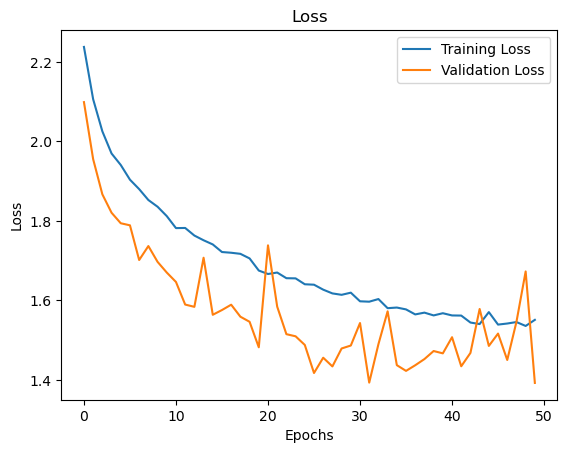

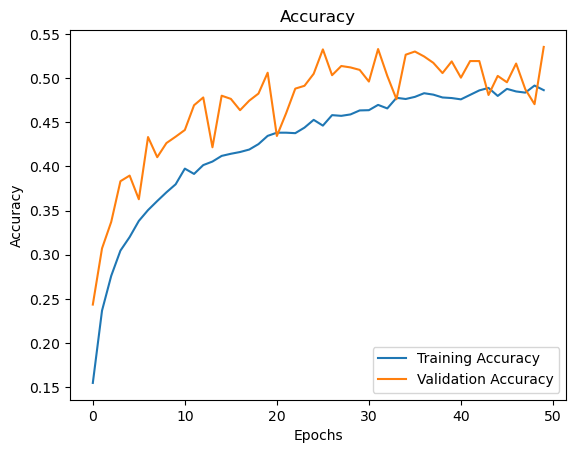

In [173]:
# Plotting Loss and Accuracy Curves:
plot_loss_curves(history_11)

That's looking much better, the loss curves are much closer to eachother. Although our model didn't perform as well on the augmented training set, it performed much better on the validation dataset.

It even looks like if we kept it training for longer (more epochs) the evaluation metrics might continue to improve.

### 7. Repeat until satisfied

We could keep going here. Restructuring our model's architecture, adding more layers, trying it out, adjusting the learning rate, trying it out, trying different methods of data augmentation, training for longer. But as you could imagine, this could take a fairly long time.

In the meantime, let's make a prediction with our trained multi-class model.

In [175]:
os.getcwd()

'C:\\Users\\shail'

In [176]:
# Save Some Images from Some Classes in Above Location to use Our Model to 
# Make a Prediction on it.

In [177]:
# Loading A Single Image: 
img1 = load_and_prep_image("chckncur (1).jpg")

In [179]:
# Making Prediction Using The M0del:
pred_11 = model_11.predict(img1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [180]:
pred_11

array([[0.15435764, 0.07633975, 0.02332325, 0.0796446 , 0.10212732,
        0.27051422, 0.00265107, 0.17961958, 0.0842544 , 0.02716814]],
      dtype=float32)

In [181]:
pred_11.shape

(1, 10)

In [185]:
# Modifying Our Function to Handle Multiclass Classification.
# Binary Classification Prediction Produces a single value whereas Multi-Class
# Classification Prediction Produces Array of Length equal to Number of Classes.

def plot_and_predict(model, filename, class_names):
    
    """
    Imports an image located at filename, makes a prediction on it with
    a trained model and plots the image with the predicted class as the title
    """
    
    # Reading in The Image and Pre-Processing it
    img = load_and_prep_image(filename)
    
    # Make a Prediction using Trained Model:
    pred_prob = model.predict(img)
    
    # Get The name of Predicted Class:
    if len(pred_prob[0]) > 1: # In case of Multi-Class Classification
        pred_class = class_names[tf.argmax(pred_prob[0])]
    
    else:
        pred_class = class_names[int(tf.round(pred_prob)[0][0])]
    
    # Plot The Image and Predicted Class:
    plt.imshow(tf.squeeze(img))
    plt.title(f" Prediction: {pred_class}")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


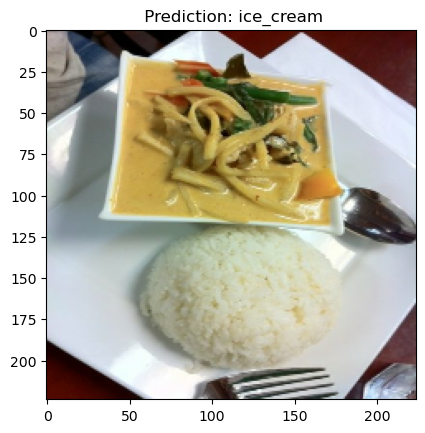

In [186]:
# Plotting Images With Preicted Label:
plot_and_predict(model_11, "chckncur (1).jpg", class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


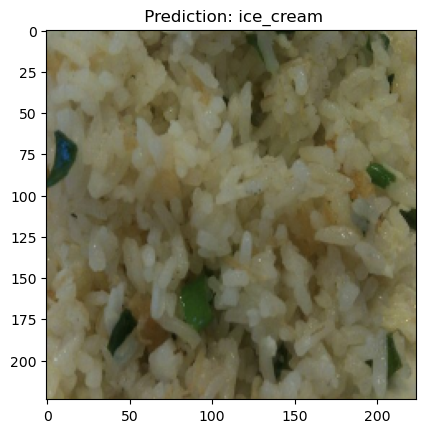

In [188]:
# Plotting Images With Preicted Label:
plot_and_predict(model_11, "frdrce.jpg", class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


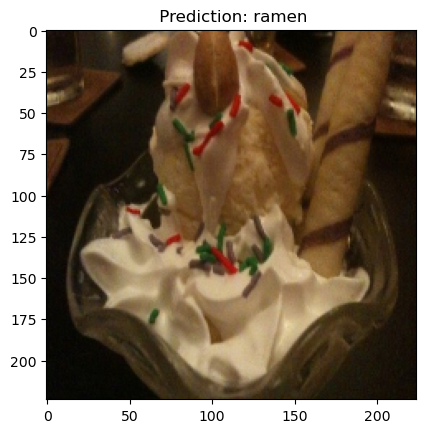

In [189]:
# Plotting Images With Preicted Label:
plot_and_predict(model_11, "iccrm (1).jpg", class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


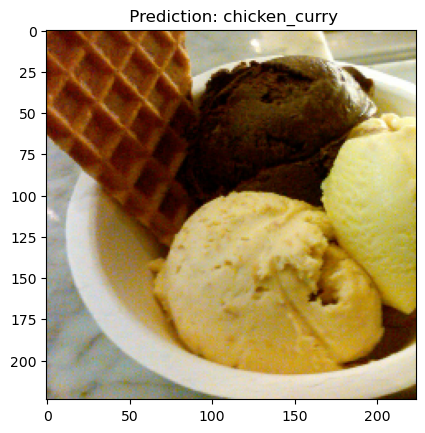

In [190]:
# Plotting Images With Preicted Label:
plot_and_predict(model_11, "iccrm (2).jpg", class_names)

Our model's predictions aren't very good, this is because it's only performing at ~50% accuracy on the test dataset.